# Introduction

## 1. Import libraries

Import all the necessary libraries required to execute the code

In [1]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from statsmodels.tsa.stattools import grangercausalitytests
import math
import calendar
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split

from statsmodels.tsa.arima.model import ARIMA
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error as MSE, mean_absolute_percentage_error as MAPE

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Data Import
The following code cell is used to download the dataset files from the Kaggle website. It only needs to be executed once.  
Additionally, you will need to generate a personal Kaggle API Token in your account settings and install kaggle (pip install kaggle)

In [2]:
# def download_kaggle_dataset(dataset, path="data"):
#     if not os.path.exists(path):
#         os.makedirs(path)

#     api = KaggleApi()
#     api.authenticate()
#     api.dataset_download_files(dataset, path=path, unzip=True)
#     print("Dataset downloaded and extracted.")

# if __name__ == "__main__":
#     download_kaggle_dataset("arashnic/food-demand")

Based on the _['retail-demand-analysis'](https://github.com/AwanRaskall/retail-demand-analysis)_ project, **Center №13** was identified as the most active in terms of order frequency and volume. Therefore, it has been selected as the primary focus for our forecasting model since:

1. More data → More orders means more historical data for the model, which means better forecast quality.
2. Pattern stability → Stores with high activity tend to have more predictable trends.
3. Minimize outliers → Stores with high costs but low orders may have unstable purchases, which will make forecasting more difficult.

In [3]:
df = pd.read_csv('data/foodDemand_train/train.csv')
df_orders = df[df['center_id'] == 13].reset_index(drop = True)
df_orders

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1171094,1,13,1885,135.86,122.28,0,1,2132
1,1068455,1,13,1993,134.86,122.28,0,1,2418
2,1105491,1,13,2539,133.86,133.86,0,0,474
3,1486384,1,13,2139,337.62,437.53,0,0,123
4,1345938,1,13,2631,252.23,437.47,0,0,162
...,...,...,...,...,...,...,...,...,...
7041,1385493,145,13,1543,484.03,485.03,0,0,270
7042,1076678,145,13,2304,486.03,485.03,0,0,149
7043,1012260,145,13,2664,241.59,335.62,0,0,770
7044,1268089,145,13,2569,241.53,337.56,0,0,798


## 3. Preparing functions

Creating functions for those actions that will be repeated several times:

In [4]:
# Plotting graphs with one or couple of data series
def plot_graph(*ys, title = None, figsize = (10, 4), xticks = range(0, 146, 6), labels = None, legend = False):                   
    plt.figure(figsize = figsize)

    for i, y in enumerate(ys):
        label = labels[i] if labels and i < len(labels) else f'Dataset {i+1}'
        plt.plot(y, label = label)                

    if title:
        plt.title(title, fontsize = 14)
    plt.xlabel('Week', fontsize = 12)
    plt.ylabel('Amount of units', fontsize = 12)
    
    plt.xticks(xticks)
    
    if legend: plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [5]:
# Plotting autocorrelation and partial autocorrelation graphs
def autoreg(data, lag = 62):         
    plot_acf(data, lags = lag)       
    plot_pacf(data, lags = lag)
    plt.tight_layout()
    plt.show()

In [6]:
# KPSS test
def test_by_KPSS(data, regression = 'c'):                 
    kpsstest = kpss(data, regression = regression)                  
    print ('Results of KPSS Test: %f' % kpsstest[0])
    print('p-value: %f' % kpsstest[1])
    print('Critical Values:')
    kpss_output = pd.Series(kpsstest[0:3], index = ['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        print('\t%s: %.3f' % (key, value))

In [7]:
# Augmented Dickey–Fuller test (ADF)
def test_by_AdFuller(data, regression = 'c'):                            
    result = adfuller(data, regression = regression)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

## 4. First acquaintance with data

In [8]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7046 entries, 0 to 7045
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     7046 non-null   int64  
 1   week                   7046 non-null   int64  
 2   center_id              7046 non-null   int64  
 3   meal_id                7046 non-null   int64  
 4   checkout_price         7046 non-null   float64
 5   base_price             7046 non-null   float64
 6   emailer_for_promotion  7046 non-null   int64  
 7   homepage_featured      7046 non-null   int64  
 8   num_orders             7046 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 495.6 KB


### 4.1. The center description

In [9]:
df_center = pd.read_csv('data/foodDemand_train/fulfilment_center_info.csv')
df_center[df_center['center_id'] == 13]

,center_id,city_code,region_code,center_type,op_area
1,13,590,56,TYPE_B,6.7


In [10]:
num_meals = df_orders['num_orders'].sum()
print(f'Total number of products ordered by center 13: {num_meals}')

Total number of products ordered by center 13: 4296545


In [11]:
df_orders['Total costs'] = df_orders.checkout_price * df_orders.num_orders
df_orders = df_orders.reset_index(drop = True)

total_costs_orders = df_orders['Total costs'].sum()
print(f'Total costs of orders for all products by center 13: {total_costs_orders}')

Total costs of orders for all products by center 13: 1127045001.1799998


Thus, the Center №13 based in city №590 and being B-type class made 7 046 orders for 4 296 545 units of products and for a total of 1 127 045 001,18 conventional monetary units over 145 weeks

### 4.2. The meal description

To create a forecasting model, we will focus on one type of product that was ordered most often or in large volumes

In [12]:
meals_num_orders = df_orders.groupby('meal_id').size().reset_index(name='num_orders')
meals_num_orders = meals_num_orders.sort_values(by = 'num_orders', ascending = False).reset_index(drop = True)

top_meal_orders = meals_num_orders.head(10)
top_meal_orders

,meal_id,num_orders
0,1062,145
1,1109,145
2,1198,145
3,1445,145
4,1311,145
5,1778,145
6,1558,145
7,1727,145
8,1754,145
9,2707,145


Since the number of orders for each product is equal, then let's calculate which product was ordered the largest number of units

In [13]:
meals_num_units = df_orders.groupby('meal_id')['num_orders'].sum().reset_index(name='num_orders')
meals_num_units = meals_num_units.sort_values(by = 'num_orders', ascending = False).reset_index(drop = True)

top_meal_units = meals_num_units.head(1)
print(f'The product with the highest number of units ordered was meal №{top_meal_units.iloc[0,0]}, amounting to {top_meal_units.iloc[0,1]} units')

The product with the highest number of units ordered was meal №1885, amounting to 334334 units


In [14]:
df_meal = pd.read_csv('data/foodDemand_train/meal_info.csv')
df_meal[df_meal['meal_id'] == 1885]

,meal_id,category,cuisine
0,1885,Beverages,Thai


To sum up, the most popular product in Center №13 was the Thai drink №1885. Given it was consistently ordered over 145 weeks with a total volume of 334 334 units across 145 separate orders, it demonstrates both long-term demand stability and high order frequency.

These characteristics make it a strong candidate for time series forecasting, as the volume and regularity of historical data provide a solid foundation for building a reliable and accurate predictive model.

## 5. Data Preprocessing

### 5.1 Data cleaning

Due to the _['retail-demand-analysis'](https://github.com/AwanRaskall/retail-demand-analysis)_ project we can note that:
* There is no one column in the table that has NaN value;
* No duplicate column/row values ​​in the table;
* Column 'id' has only unique values.

We need:  
* Delete unnecessary columns and rows;
* Rename columns so they express clear meaning;
* Outliers testing.

#### Remove unrequired rows

In [15]:
df_orders = df_orders.loc[df_orders['meal_id'] == 1885]
df_orders = df_orders.reset_index(drop = True)

#### Remove unrequired columns

In [16]:
del df_orders['emailer_for_promotion']
del df_orders['homepage_featured']
del df_orders['center_id']
del df_orders['meal_id']

#### Rename columns

In [17]:
df_orders = df_orders.rename(columns={'num_orders': 'num_units'})

### 5.2 Detecting Outliers

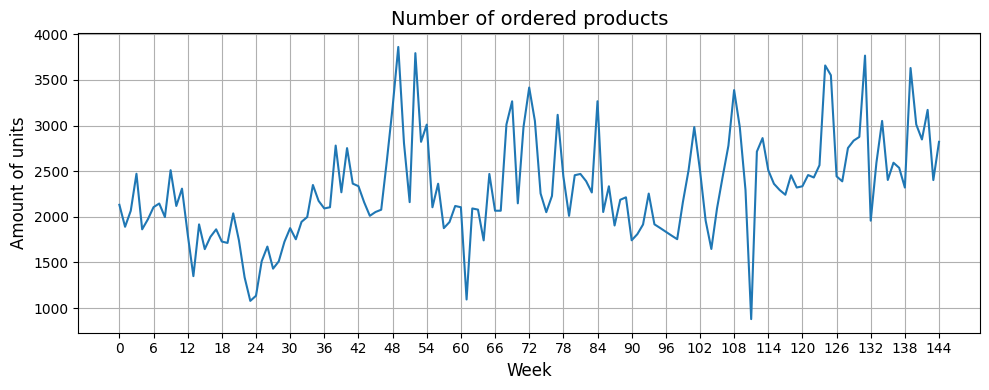

In [18]:
plot_graph(df_orders['num_units'], title = 'Number of ordered products')

Outliers in number of ordered beverages:
 49     3862
52     3794
111     879
124    3659
125    3552
131    3767
139    3631
Name: num_units, dtype: int64


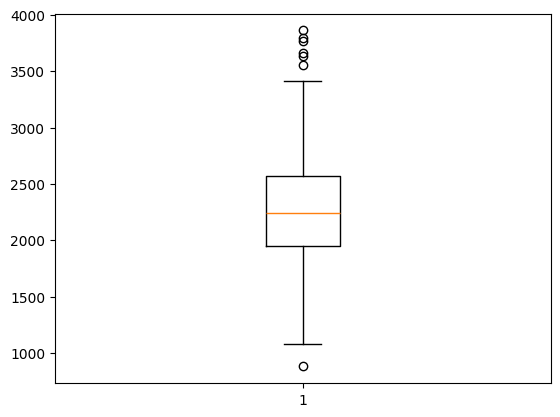

In [19]:
# IQR method emissions
Q1 = df_orders['num_units'].quantile(0.25)
Q3 = df_orders['num_units'].quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

outliers = df_orders[(df_orders['num_units'] < lower) | (df_orders['num_units'] > upper)]
print('Outliers in number of ordered beverages:' + '\n', outliers['num_units'])

# Graph of Outliers
plt.boxplot(df_orders['num_units'])
plt.show()

In [20]:
# Determine in which months our outliers were (1 year = 0-51 week)
def week_recogniton(week_num):
    year = week_num // 52
    week_of_year = week_num % 52
    month = math.ceil((week_of_year + 1) * 12 / 52)
    start_week = math.floor((month - 1) * 52 / 12)
    week_in_month = week_of_year - start_week + 1
    return year + 1, month, week_in_month 

# Print index and number of week (from 1) for outliers
for w in outliers.index:
    year, m, wm = week_recogniton(w)
    print(f"Outliers with index {w} (week № {w + 1}): {wm} week of {calendar.month_name[m]} in the {year} year")

Outliers with index 49 (week № 50): 3 week of December in the 1 year
Outliers with index 52 (week № 53): 1 week of January in the 2 year
Outliers with index 111 (week № 112): 4 week of February in the 3 year
Outliers with index 124 (week № 125): 4 week of May in the 3 year
Outliers with index 125 (week № 126): 1 week of June in the 3 year
Outliers with index 131 (week № 132): 2 week of July in the 3 year
Outliers with index 139 (week № 140): 2 week of September in the 3 year


We note that the spikes in order levels do not occur on holidays, which means that this is not explained by increased customer demand in preparation for the holidays. We can also conclude that this is not a seasonal anomaly, since the spikes do not repeat every year.  

### 5.3 Correlational analysis

#### Visual analysis

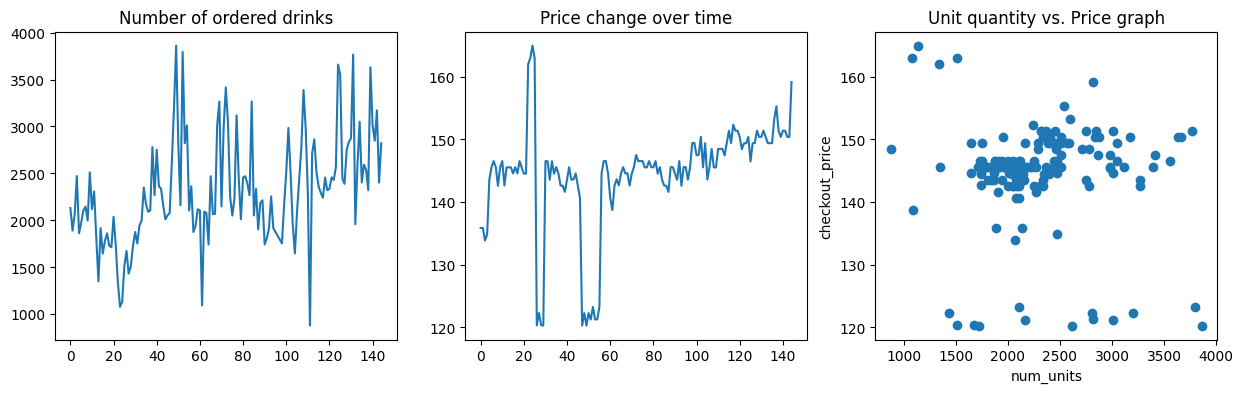

In [21]:
plt.figure('Dependence', figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(df_orders['num_units'])
plt.title('Number of ordered drinks')

plt.subplot(1,3,2)
plt.plot(df_orders['checkout_price'])
plt.title('Price change over time')

plt.subplot(1,3,3)
plt.scatter(df_orders['num_units'], df_orders['checkout_price'])
plt.title("Unit quantity vs. Price graph")
plt.xlabel('num_units')
plt.ylabel('checkout_price')

plt.show()

There is virtually no clear relationship between order quantity and price: prices mostly stay within a narrow range (140–150) regardless of the volume ordered

#### Correlation coefficient

In [22]:
r, p_value = pearsonr(df_orders['num_units'], df_orders['checkout_price'])     
print('Correlation value (r) = ', r)
print('Significance (p_value) = ', p_value)

Correlation value (r) =  -0.08066955837086605
Significance (p_value) =  0.33476736871453383


Thus, the value of the Pearson correlation coefficient, ∣r∣ ≤ 0.3, indicates a **very weak inverse linear relationship** between the variables. At the same time p-value = 0.3348 is significantly greater than the threshold of 0.05, that is, this “relationship” is **not statistically insignificant**. In other words, based on these data, it is impossible to conclude about a linear relationship between volume and price

#### Granger Causality Test  
Granger Causality Test checks whether knowing past values of series 𝑋 helps improve the forecasting of series 𝑌, beyond what past values of 𝑌 alone provide.

In [23]:
grangercausalitytests(df_orders[['checkout_price', 'num_units']], maxlag = 12, verbose = True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0006  , p=0.9798  , df_denom=141, df_num=1
ssr based chi2 test:   chi2=0.0007  , p=0.9796  , df=1
likelihood ratio test: chi2=0.0007  , p=0.9796  , df=1
parameter F test:         F=0.0006  , p=0.9798  , df_denom=141, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1660  , p=0.3147  , df_denom=138, df_num=2
ssr based chi2 test:   chi2=2.4165  , p=0.2987  , df=2
likelihood ratio test: chi2=2.3964  , p=0.3017  , df=2
parameter F test:         F=1.1660  , p=0.3147  , df_denom=138, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9001  , p=0.4430  , df_denom=135, df_num=3
ssr based chi2 test:   chi2=2.8403  , p=0.4169  , df=3
likelihood ratio test: chi2=2.8123  , p=0.4215  , df=3
parameter F test:         F=0.9001  , p=0.4430  , df_denom=135, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8025  , p=0.5256  

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{np.int64(1): ({'ssr_ftest': (np.float64(0.0006428993467985398),
    np.float64(0.9798072870331174),
    np.float64(141.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(0.0006565780563048917),
    np.float64(0.9795574193015217),
    np.int64(1)),
   'lrtest': (np.float64(0.0006565765595496487),
    np.float64(0.9795574425971992),
    np.int64(1)),
   'params_ftest': (np.float64(0.0006428993468832068),
    np.float64(0.9798072870316425),
    np.float64(141.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(1.1660264693087512),
    np.float64(0.3146533335738966),
    np.float64(138.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(2.416547610306542),
    np.float64(0.29871247056916433),
    np.int64(2)),
   'lrtest': (np.float64(2.396356228351692),
    np.float64(0.30174345355305854),
    np.int64(2)),
   'params_ftest': (np.float64(1.1660264693089706),
    np.float64(0.31465333357382463),
    np.float64(138.0),
    2.0)},
   array([[0., 0., 1., 0.

Across all tested lags (1–12) in the results for 'price → num_orders':
* The SSR-based F-test and the other tests all yield p > 0.05
* For no lag do we reject that 'price does not Granger-cause num_orders'

To sum up, there is no statistically significant predictive power of price on the number of orders over a 12-week horizon. In other words, past values of price do not improve the demand forecast beyond what demand’s own history already provides

### 5.4 Handling Outliers

Unfortunately, we do not have data on whether these were critical business events such as sales, promotions, or marketing campaigns. Also, there was no dependence of the increase in the order volume on the price. Therefore, in this case, we will prefer to change the outliers.

* For outliers with indexes 49, 52, 111, 131, 139 we will find the median taking into account three values: previous, present and future.
* For values ​​with indices 124, 125, we will use the average of two neighbors.

In [24]:
# Median with window = 3
outliers1 = [49, 52, 111, 131, 139]

rolling_med = df_orders['num_units'].rolling(window = 3, center = True).median()
df_orders.loc[outliers1, 'num_units'] = rolling_med.loc[outliers1]
print(df_orders.loc[outliers1, 'num_units'])

# Average of two neighbors
outliers2 = [124, 125]

for i in outliers2:
    prev_val = df_orders.at[i - 1, 'num_units']
    next_val = df_orders.at[i + 1, 'num_units']
    df_orders.at[i, 'num_units'] = (prev_val + next_val) / 2
print(df_orders.loc[outliers2, 'num_units'])

49     3201
52     2822
111    2294
131    2876
139    3012
Name: num_units, dtype: int64
124    3059.0
125    2751.5
Name: num_units, dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_14836\3210987412.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2751.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_orders.at[i, 'num_units'] = (prev_val + next_val) / 2


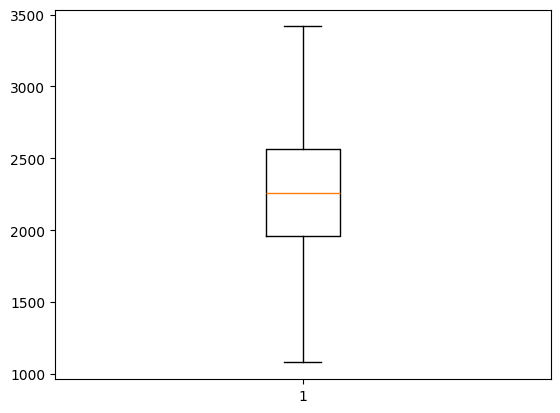

In [25]:
# Checking final data
plt.boxplot(df_orders['num_units'])
plt.show()

### 5.5 Seasonal–Trend Decomposition

Create a separate table with only the data column we need

In [26]:
df_work = pd.DataFrame({'week': df_orders.week,'num_units': df_orders.num_units.astype(int)})
df_work.set_index('week', inplace=True)
df_work

,num_units
week,
1,2132
2,1891
3,2067
4,2472
5,1863
...,...
141,3012
142,2848
143,3172


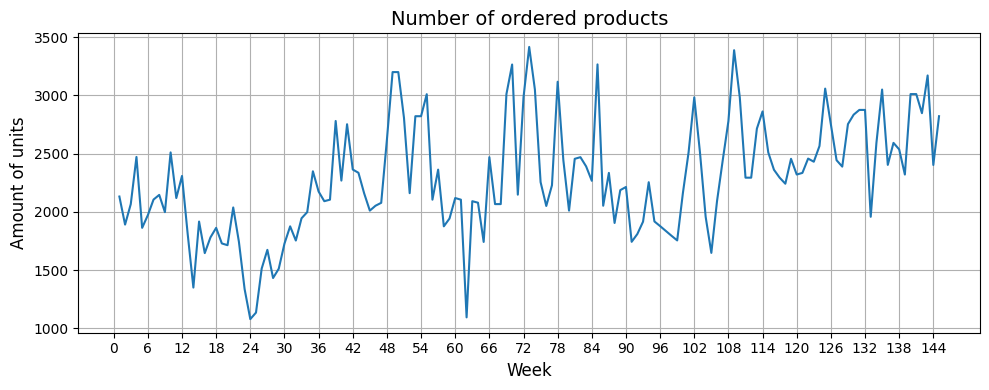

In [27]:
# Outputting a graph of the final input data
plot_graph(df_work, title = 'Number of ordered products')

#### Trend  
Use a **Hodrick-Prescott Filter** to determine the trend movements in data. Since we have weekly data, then λ = 129 600

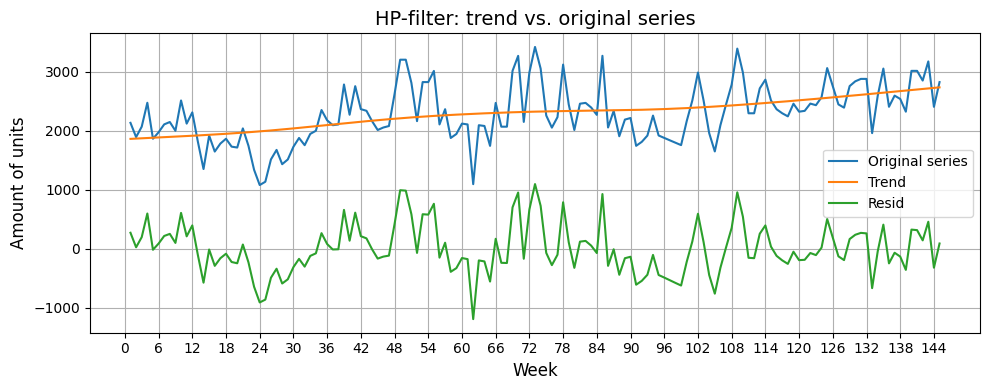

In [28]:
trend, resid = hpfilter(df_work, lamb = 129600)
plot_graph(df_work, resid, trend, title = 'HP-filter: trend vs. original series', labels = ['Original series', 'Trend', 'Resid'], legend = True)

It can be seen that with the value λ = 129 600, the trend looks very smooth.  
Since the trend is important to us, we will try to consider alternative methods to see more locally: **LOESS smoothing**

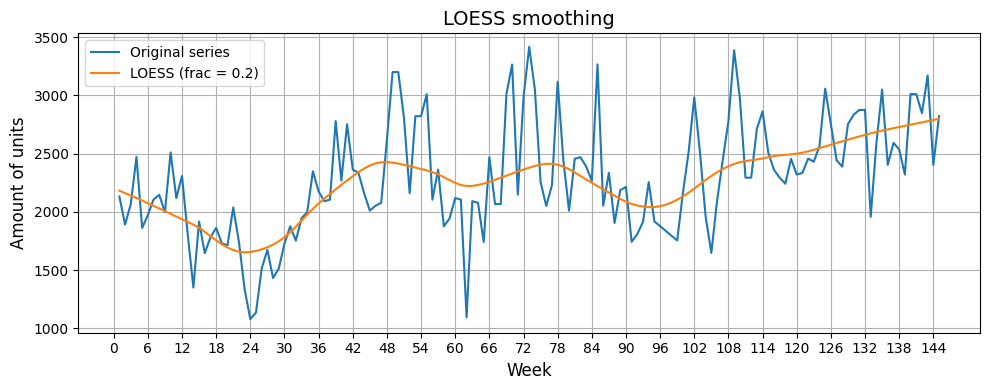

In [29]:
trend_loess = lowess(df_work['num_units'], df_work.index.astype(int), frac = 0.2, return_sorted = False)
trend_loess = pd.Series(trend_loess, index = df_work.index)

plot_graph(df_work, trend_loess, title = 'LOESS smoothing', labels = ['Original series', 'LOESS (frac = 0.2)'], legend = True)

Thus, the trend is non-linear: the rate of growth and decline changes over time. The LOESS chart also shows that:
- The trend clearly "tilts" down until ~24th week, then there is an increase, then a small decrease again and an increase by the end of the series;
- The amplitude of short-term fluctuations (LOESS residuals) is approximately constant throughout, does not “inflate” with a high trend -> Model - additive

#### Seasonality

Plot the **autocorrelation** and partial autocorrelation graphs

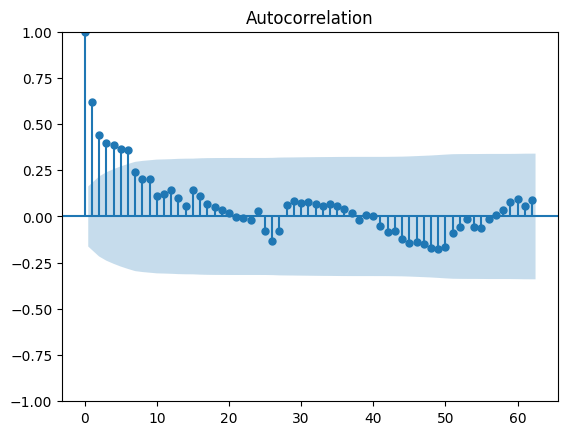

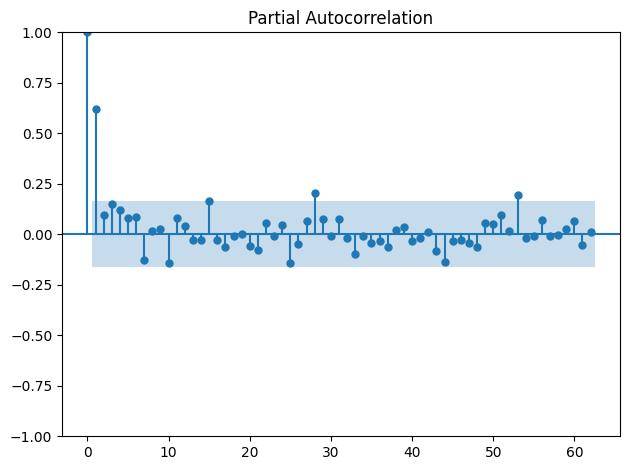

In [30]:
autoreg(df_work)

What we can see on the autocorrelation plot:
* Rapid decay of autocorrelation after lag 1 – 6: the series is highly correlated with itself at very short horizons (6 weeks), then correlations taper off toward zero.
* No prominent spikes at 'seasonal' lags (52 weeks for annual seasonality, or 12 weeks for quarterly). Any small blips around those lags remain within the confidence bounds, so they’re not statistically significant.

Conduct additional **Spectral analysis** _(Fast Fourier Transform)_ to exclude the suspicion of a cycle (e.g. annual, quarterly) despite the ACF.

In [31]:
# For the frequency array we use d = 1, since the samples are taken with a step of one week
avg_units = df_work['num_units'].values - df_work['num_units'].mean()
fft = np.fft.fft(avg_units)
freqs = np.fft.fftfreq(len(avg_units), d = 1)

# ignore the zero frequency and take the peak
peak_freq = freqs[np.argmax(np.abs(fft)[1:]) + 1]
period = int(round(1 / peak_freq))
print("Estimated period:", period)

Estimated period: 72


What both methods tell:
* _Autocorrelation:_ The data show short-term dependence, but no clear seasonal cycle. There is no lag at which the ACF jumps back up conspicuously above the significance bands;
* _Fast Fourier Transform:_ the dominant spectral peak was found at a frequency corresponding to a period of 72 weeks (the strongest repeating cycle).

#### Decomposition

In this section, decomposing a time series into its components will be done only for _72-week seasomality_. **Seasonal_decompose** from statsmodels will be used with period 72 (for 72-week seasonality).

For _zero seasonality_, to make the residuals not zero, but contain noise or possible short-term effects, the series is split into two components: trend + residuals. For this, the **HP filter** were used in the Trend Analysis section.

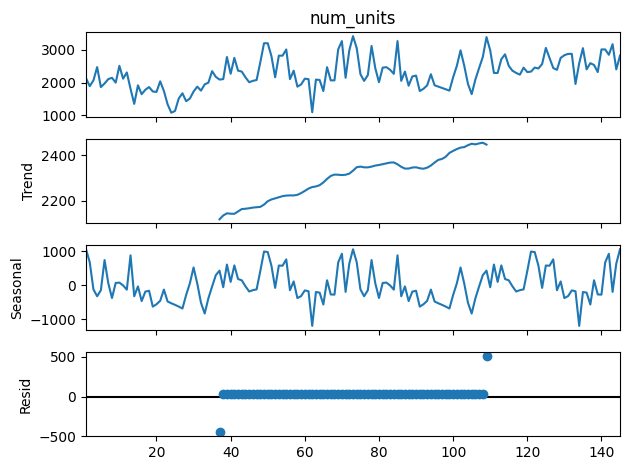

In [32]:
decom72 = seasonal_decompose(df_work['num_units'], model = 'add', period = 72)
decom72.plot()
plt.show()

What two charts tell:  
1. **Zero seasonality**:
    * _Trend_: the trend shape is almost linear, and the smoothing level shows that the trend only catches long-term changes, without reacting to individual spikes;
    * _Residuals_: they strongly flutter around zero, without a noticeable slope or shift. This means that the trend has leveled out the long-term non-stationarity;
    * The decomposition is additive: everything 'non-trend' (noise, rare peaks) went into the residuals, their dispersion does not depend on the trend level.  
2. **72-week seasonality**:
    * Having only 145 points and is barely enough for the algorithm to estimate a stable seasonal pattern giving a 72-week period;
    * _Trend_: a smooth upward curve - orders really do climb over time;
    * _Seasonal_: a jagged, noisy line that doesn’t repeat clearly. It may be due to not enough cycles, and the algorithm is just fitting whatever fluctuations it can;
    * _Residual_: almost identically zero everywhere—an artifact of over.

### 5.6 Stationarity Check and Column Engineering

#### Stationarity

In [33]:
test_by_KPSS(df_work)
print('')
test_by_AdFuller(df_work)

Results of KPSS Test: 0.798536
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

ADF Statistic: -2.919466
p-value: 0.043131
Critical Values:
	1%: -3.478
	5%: -2.882
	10%: -2.578


C:\Users\user\AppData\Local\Temp\ipykernel_14836\3308023662.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(data, regression = regression)


* KPSS says the series is not stationary;
* ADF says the series does not have a unit root (is stationary).

This is a typical "gap" between the unit-root and level-stationarity tests, meaning that the data has either a weak trend or borderline behavior

#### Column Engineering

We will create a new table _df_work_ds_ with a ds column that will display timestamps (datetime64), since we plan to use some functions and models that take these values ​​as input.  
Firt week will start from 2022-01-02 (sun) and then the second week will be 2022-01-09 and so on

In [34]:
start = pd.to_datetime('2022-01-02')
df_work_ds = df_work.copy()
df_work_ds['ds'] = start + pd.to_timedelta(df_work_ds.index - 1, unit='W')
df_work_ds.head()

,num_units,ds
week,,
1,2132,2022-01-02
2,1891,2022-01-09
3,2067,2022-01-16
4,2472,2022-01-23
5,1863,2022-01-30


## 6. Modeling  

### 6.1 Metrics functions

There are 2 functions that we will use to evaluate the models / predictions:
* _evaluate_model_ - it extracts model's AIC and BIC values based on a fitted model;
* _accurancy_metrics_ - the function determines the main accuracy metrics by comparing the actual data and the data that was predicted.

The metrics used to evaluate models are:
* _AIC_ - an information‐theoretic measure that balances model fit and complexity;
* _BIC_ - it is ratio similar to AIC but imposes a stronger penalty for model complexity.

The metrics used to evaluate the accurancy of models are:
* _MSE_ - Mean Squared Error is computed as the average of the squared errors;
* _RMSE_ - Root Mean Squared Error is the square root of the Mean Squared Error;
* _MAPE_ - Mean Absolute Percent Error is computed by taking the error for each prediction, divided by the actual value;

In [35]:
df_eval_models = pd.DataFrame(columns = ['Model', 'AIC', 'BIC'])

def evaluate_model(eval_models, fitmodel, model_name, metrics_show = False, table_show = False, clean = False):
    aic = fitmodel.aic
    bic = fitmodel.bic
    
    if clean: eval_models = eval_models[0:0]

    eval_models.loc[len(eval_models)] = [model_name, aic, bic] 
    if metrics_show: print(f'AIC of {model_name} = {aic:.2f} \nBIC of {model_name} = {bic:.2f}')
    
    if table_show: 
        eval_models = eval_models.drop_duplicates()
        display(eval_models.style.highlight_min(subset = ['AIC', 'BIC'], color = 'lightgreen'))

    return eval_models

In [36]:
metrics_accur = pd.DataFrame(data = None, columns = ['Model', 'MSE', 'RMSE', 'MAPE'])

def accurancy_metrics(metrics_accur, model_name, data, prediction, show = False):
    
    mse = MSE(data[-len(prediction):], prediction)
    rmse = math.sqrt(mse)
    mape = MAPE(data[-len(prediction):], prediction)

    metrics_accur.loc[len(metrics_accur)] = [model_name, mse, rmse, mape]
    metrics_accur = metrics_accur.drop_duplicates()

    if show: display(metrics_accur.style.highlight_min(subset = ['MSE', 'RMSE', 'MAPE'], color = 'yellow'))
    
    return metrics_accur

### 6.2 Model creation

In this subsection we create different machine learning models. We decided to test the following algorithms:
 * ARIMA
 * SARIMA
 * XGBoost
 * Random Forest

Based on Seasonality analysis (section 5.5) we are going to use non-seasonal components for Arima and 72-week seasonality for Sarima.

#### **ARIMA**

For the nonseasonal ARIMA model, we will offer several options for coefficients, based on manual selection (acf & pacf), as well as using a special function to automatically find the best value:
* **p** is the number of autoregressive terms (based on pacf);
* **d** is the number of nonseasonal differences needed for stationarity;
* **q** is the number of lagg (based on acf).

*Manual selection:*

| P | D | Q |Comment|
|---|---|---|---|
| 0 | 1 | 0 |*Random walk* is the behavior when the time series shows irregular growth|
| 0 | 1 | 5 |ACF significant value at lag 5|
| 1 | 1 | 6 |Add 6 for MA as last significant lag due to ACF|
| 2 | 1 | 0 |PACF is slightly above threshold at lag 2, so we can give the model a chance to capture longer autoregression|
| 3 | 1 | 1 |Add 3 for AR as last significant lag due to PACF|

For *automatic selection* we use [AutoARIMA from StatsForecast](https://nixtlaverse.nixtla.io/statsforecast/docs/models/autoarima.html) function, that automatically discovers the optimal order for an ARIMA model.

Create some ARIMA models **manually**. 

1. Preparing the dataset  

So that the Arima model can orient itself to the dates of the input data, we need to make the ds column the index of the table and also specify the frequency of the data (to give the value of the week).

In [37]:
df_arima = df_work_ds.copy()

df_arima= df_arima.set_index('ds')
df_arima = df_arima.asfreq('W')

2. Train-Test Splitting

In [38]:
train_arima, test_arima = train_test_split(df_arima, test_size = 0.2, shuffle = False)

3. Modeling

In [39]:
# Function that creates an ARIMA model and trains it using maximum likelihood (fit)
def build_arima(data, order):
    model = ARIMA(data, order = order)
    fit_model = model.fit()
    return fit_model

In [40]:
# 1st model and AIC / BIC values
arima_fit_model1 = build_arima(train_arima, (0,1,0))
df_eval_models = evaluate_model(df_eval_models, arima_fit_model1, 'ARIMA (0, 1, 0)', True)

AIC of ARIMA (0, 1, 0) = 1724.83 
BIC of ARIMA (0, 1, 0) = 1727.57


4. Evaluating

In [41]:
arima_fit_model2 = build_arima(train_arima, (0,1,5))
df_eval_models = evaluate_model(df_eval_models, arima_fit_model2, 'ARIMA (0, 1, 5)')

arima_fit_model3 = build_arima(train_arima, (1,1,6))
df_eval_models = evaluate_model(df_eval_models, arima_fit_model3, 'ARIMA (1, 1, 6)')

arima_fit_model4 = build_arima(train_arima, (2,1,0))
df_eval_models = evaluate_model(df_eval_models, arima_fit_model4, 'ARIMA (2, 1, 0)')

arima_fit_model5 = build_arima(train_arima, (3,1,1))
df_eval_models = evaluate_model(df_eval_models, arima_fit_model5, 'ARIMA (3, 1, 1)', table_show= True)

,Model,AIC,BIC
0,"ARIMA (0, 1, 0)",1724.827670,1727.572602
1,"ARIMA (0, 1, 5)",1708.667615,1725.137208
2,"ARIMA (1, 1, 6)",1712.239199,1734.198656
3,"ARIMA (2, 1, 0)",1713.771559,1722.006355
4,"ARIMA (3, 1, 1)",1709.106627,1722.831288


Now, let's use **Automatic order search**. 

1. Preparing the dataset  

For AutoARIMA of StatsForecast train set have to consist of 3 columns:
* **unique_id** - series identifier (for one series - any constant, eg '1')
* **ds** - timestamp of each point (with frequency)
* **y** - value of the row (our num_orders)

In [42]:
df_arima_auto = df_work_ds.copy()

df_arima_auto.rename(columns = {'num_units': 'y'}, inplace = True)
df_arima_auto['unique_id'] = '1'
df_arima_auto

,y,ds,unique_id
week,,,
1,2132,2022-01-02,1
2,1891,2022-01-09,1
3,2067,2022-01-16,1
4,2472,2022-01-23,1
5,1863,2022-01-30,1
...,...,...,...
141,3012,2024-09-08,1
142,2848,2024-09-15,1
143,3172,2024-09-22,1


2. Train-Test Splitting

In [43]:
au_train_arima, au_test_arima = train_test_split(df_arima_auto, test_size = 0.2, shuffle = False)

3. Modeling

In [44]:
model_arima = AutoARIMA(
    seasonal = False,    
    season_length = 1,

    max_p = 3,                
    max_q = 6,                
    max_d = 2, 

    d = None, # automatic selection d through ADF/KPSS                
    
    start_p = 1,
    start_q = 1,

    ic ="aic",

    stepwise = True, # quick Hyndman-style enumeration
    trace = False, # not display search progress

    allowmean  = True,    # include a non-zero intercept
    allowdrift = True,    # include a drift term when d > 0
)

sf_arima = StatsForecast(models = [model_arima], freq = "W", n_jobs = 1)
sf_arima_fit = sf_arima.fit(au_train_arima) 
print(f'Optimal orders for ARIMA model found automatically are: {arima_string(sf_arima.fitted_[0,0].model_)}')

Optimal orders for ARIMA model found automatically are: ARIMA(1,1,1)                   


4. Evaluating

Compare aic and bic values with other ARIMA models and see that ARIMA (1, 1, 1) is the best.

In [45]:
sf_arima_fitted = sf_arima.fitted_[0,0].model_
df_eval_models.loc[len(df_eval_models)] = ['ARIMA (1, 1, 1)', sf_arima_fitted['aic'], sf_arima_fitted['bic']]
df_eval_models.style.highlight_min(subset=['AIC', 'BIC'], color='lightgreen')

,Model,AIC,BIC
0,"ARIMA (0, 1, 0)",1724.827670,1727.572602
1,"ARIMA (0, 1, 5)",1708.667615,1725.137208
2,"ARIMA (1, 1, 6)",1712.239199,1734.198656
3,"ARIMA (2, 1, 0)",1713.771559,1722.006355
4,"ARIMA (3, 1, 1)",1709.106627,1722.831288
5,"ARIMA (1, 1, 1)",1705.399838,1713.634634


5. Prediction

In [46]:
sf_arima_forecast = sf_arima_fit.predict(h = len(au_test_arima))

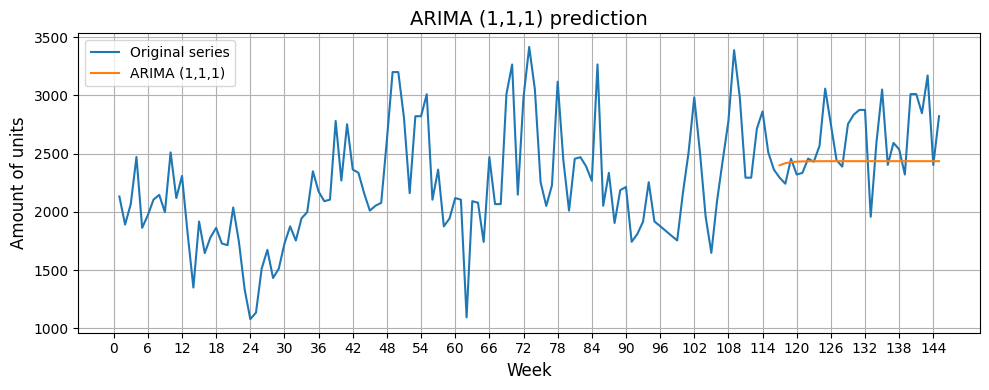

In [47]:
sf_arima_forecast.index = range(len(au_train_arima) + 1, len(au_train_arima) + 1 + len(sf_arima_forecast))

plot_graph(df_work_ds['num_units'],sf_arima_forecast['AutoARIMA'], title = 'ARIMA (1,1,1) prediction', labels = ['Original series', 'ARIMA (1,1,1)'], legend = True)

We can see a flat "blank" prediction (orange plot). This is absolutely expected behavior of pure h-step ARIMA(1,1,1) without trend (drift), because ARIMA(1,1,1) without drift is a random walk.

#### **SARIMA**

For SARIMA model we also use AutoARIMA of StatsForecast but already with the seasonal component included.  
Based on _HP filter_ we take seasonality equaled 72. Dataset will be used the same as in ARIMA - df_arima_auto

1. Modeling

In [48]:
model_sarima = AutoARIMA(
    seasonal = True, season_length = 72, # seasonality = 72

    max_p = 3, max_q = 6, max_d = 2, 
    d = None,               
    start_p = 1, start_q = 1,
    
    # Seasonal part
    max_P = 2, max_Q = 2, max_D = 1,
    D = None, # Automatic selection of seasonal differences
    start_P = 1,    # starting point for P
    start_Q = 1,    # starting point for Q

    ic ="aic",

    stepwise = True,
    trace = False)

sf_sarima = StatsForecast(models = [model_sarima], freq = "W", n_jobs = 1)
sf_sarima_fit = sf_sarima.fit(au_train_arima) 
print(f'Optimal orders of SARIMA model found automatically are: {arima_string(sf_sarima.fitted_[0,0].model_)}')

Optimal orders of SARIMA model found automatically are: ARIMA(1,1,1)                   


2. Evaluating

Compare aic and bic values with best ARIMA model and see that the coeffs are the same. That means that we will predict using both models of one class and evaluate based on the accuracy of the prediction.

In [49]:
sf_sarima_fitted = sf_arima.fitted_[0,0].model_
df_eval_models.loc[len(df_eval_models)] = ['SARIMA (1, 1, 1)', sf_sarima_fitted['aic'], sf_sarima_fitted['bic']]
df_eval_models.style.highlight_min(subset=['AIC', 'BIC'], color='lightgreen')

,Model,AIC,BIC
0,"ARIMA (0, 1, 0)",1724.827670,1727.572602
1,"ARIMA (0, 1, 5)",1708.667615,1725.137208
2,"ARIMA (1, 1, 6)",1712.239199,1734.198656
3,"ARIMA (2, 1, 0)",1713.771559,1722.006355
4,"ARIMA (3, 1, 1)",1709.106627,1722.831288
5,"ARIMA (1, 1, 1)",1705.399838,1713.634634
6,"SARIMA (1, 1, 1)",1705.399838,1713.634634


3. Prediction

In [50]:
sf_sarima_forecast = sf_sarima_fit.predict(h = len(au_test_arima))

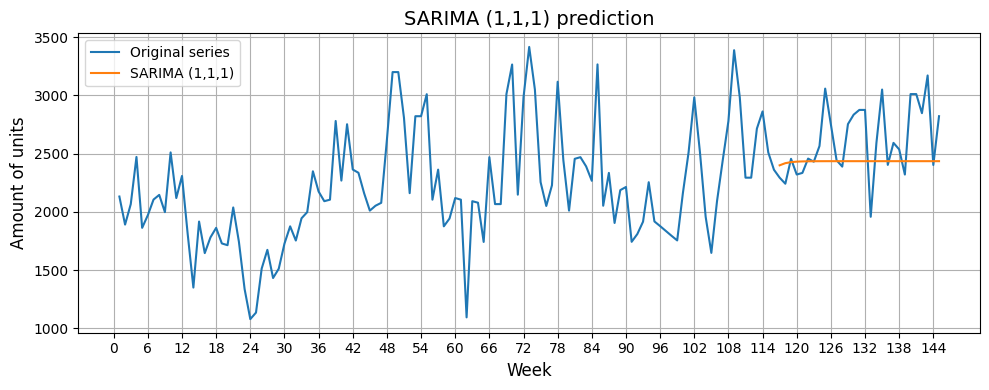

In [51]:
sf_sarima_forecast.index = range(len(au_train_arima) + 1, len(au_train_arima) + 1 + len(sf_sarima_forecast))

plot_graph(df_work_ds['num_units'],sf_sarima_forecast['AutoARIMA'], title = 'SARIMA (1,1,1) prediction', labels = ['Original series', 'SARIMA (1,1,1)'], legend = True)

Here we can also observe the same forecast behavior as the Arima model

#### **Xgboost**

XGBoost is a gradient boosting algorithm over decision trees that is well suited for regression problems, including time series forecasting, if the features are organized correctly.

The model components:
* **n_estimators** – number of trees / number of boosting iterations;
* **learning_rate** – gradient boosting step;
* **max_depth** – maximum depth of each tree;
* **subsample** – proportion of rows/features to build each tree;
* **colsample_bytree** - fraction of features for each tree;

* **gamma** – minimum improvement of loss function for node split;
* **lambda/alpha** – L2/L1 regularization.

##### _Zero seasonality_

Season_length=1 → do not add explicit seasonal lags (lag_72, etc.) and do not create sinusoidal features.

1. Preparing the dataset  

In [52]:
df_xgboost = df_work.copy()

# Clear trend - add observation number as a feature
df_xgboost['t'] = np.arange(len(df_xgboost))

# Normal lags 1–10
for lag in range(1, 11):
    df_xgboost[f'lag_{lag}'] = df_xgboost['num_units'].shift(lag)

# Exponential smoothing
df_xgboost['ewm_a03'] = df_xgboost['num_units'].ewm(alpha=0.3).mean()

# Moving average 
for w in (4,8,12):
    df_xgboost[f'roll_{w}'] = df_xgboost['num_units'].shift(1).rolling(w).mean()

# Remove gaps
df_xgboost = df_xgboost.dropna()
df_xgboost

,num_units,t,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,ewm_a03,roll_4,roll_8,roll_12
week,,,,,,,,,,,,,,,,
13,1810,12,2309.0,2119.0,2511.0,1998.0,2146.0,2106.0,1972.0,1863.0,2472.0,2067.0,2092.946358,2234.25,2128.000,2132.166667
14,1350,13,1810.0,2309.0,2119.0,2511.0,1998.0,2146.0,2106.0,1972.0,1863.0,2472.0,1868.540478,2187.25,2121.375,2105.333333
15,1917,14,1350.0,1810.0,2309.0,2119.0,2511.0,1998.0,2146.0,2106.0,1972.0,1863.0,1883.147683,1897.00,2043.625,2060.250000
16,1646,15,1917.0,1350.0,1810.0,2309.0,2119.0,2511.0,1998.0,2146.0,2106.0,1972.0,1811.766157,1846.50,2020.000,2047.750000
17,1781,16,1646.0,1917.0,1350.0,1810.0,2309.0,2119.0,2511.0,1998.0,2146.0,2106.0,1802.514788,1680.75,1957.500,1978.916667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,3012,140,3012.0,2321.0,2537.0,2593.0,2404.0,3051.0,2592.0,1958.0,2876.0,2876.0,2763.973869,2615.75,2558.500,2650.750000
142,2848,141,3012.0,3012.0,2321.0,2537.0,2593.0,2404.0,3051.0,2592.0,1958.0,2876.0,2789.181708,2720.50,2690.250,2672.250000
143,3172,142,2848.0,3012.0,3012.0,2321.0,2537.0,2593.0,2404.0,3051.0,2592.0,1958.0,2904.027196,2798.25,2722.250,2673.333333


2. Train-Test Splitting

In [53]:
train_xgb, test_xgb = train_test_split(df_xgboost, test_size = 0.2, shuffle = False)

X_train_xgb, y_train_xgb = train_xgb.drop('num_units', axis = 1), train_xgb['num_units']
X_test_xgb, y_test_xgb = test_xgb.drop('num_units', axis = 1), test_xgb['num_units']

3. Modeling


_Hyperparameter Search:_ 
* **param_grid** - dictionary with hyperparameter grid;
* `RandomizedSearchCV`- finds the best combinations of hyperparameters by iterating over random samples from a grid. Advantages: simplicity, no external dependencies;
* `TimeSeriesSplit(n_splits = 5)` - splits the data into 5 "sliding" folds, where in each subsequent fold the training sample is expanded, and the test sample is the next piece of the time series;
* `XGBRegressor`(random_state = 42) - the basic model fixes random number generation for reproducibility;
* **n_iter** - random combinations from the entire grid. Using the trial and error method, it was found that increasing the number to 100 allows finding the best result;
* **scoring** - metrics for selection

Using _RandomizedSearchCV_ and _XGBRegressor_ we find the best combinations of hyperparameters (tree depth, learning_rate, etc.) without early stopping.

In [54]:
param_grid = {
    'n_estimators': [100, 300, 500], # Test 100, 300 and 500 to evaluate the speed ↔ quality trade-off
    'max_depth': [3, 5, 7], # from "shallow" to "moderately deep" trees to control overfitting
    'learning_rate': [0.01, 0.05, 0.1],  # a smaller step gives smoother learning but requires more trees
    'subsample': [0.6, 0.8, 1.0], # to introduce stochasticity and prevent overfitting
    'colsample_bytree': [0.6, 0.8, 1.0] # to introduce stochasticity and prevent overfitting
}

search = RandomizedSearchCV(
    estimator = XGBRegressor(random_state = 42),
    param_distributions = param_grid,
    n_iter = 100,
    cv = TimeSeriesSplit(n_splits = 5),
    scoring = 'neg_mean_squared_error',
    n_jobs = -1, # Parallel on all CPU cores
    verbose = 1  # Show search progress
)

# Run hyperparameter selection on training data
search.fit(X_train_xgb, y_train_xgb)

best_params = search.best_params_
print("Best parameters:", best_params)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


_Training of the model:_  
Take the best parameters and switch to the native API - xgb.DMatrix + xgb.train

* `DMatrix` is the basic data storage for XGBoost used by all XGBoost algorithms including both training, prediction and explanation;
* `xgb.train` - native training method / an advanced interface for training an xgboost model;
* **num_boost_round** - total number of iterations;
* **early_stopping_rounds** — if the metric does not improve within n validation iterations, training will stop early. Early stopping allows you to automatically select the optimal number of trees, preventing overfitting and saving training time

If switch to other versions of XGBRegressor.fit(), where the early_stopping_rounds and eval_set arguments are supported, then you can do without xgb.train

In [55]:
# Preparing DMatrix for xgb.train
dtrain = xgb.DMatrix(X_train_xgb, label = y_train_xgb)
dtest  = xgb.DMatrix(X_test_xgb, label = y_test_xgb)

params = best_params.copy()
num_boost_round = params.pop('n_estimators') # remove the n_estimators key from params, since in xgb.train the number of iterations is specified by a separate argument num_boost_round
params.update({
    'objective':    'reg:squarederror', # regression problem with squared error
    'eval_metric':  'rmse' # RMSE will be output at the validation stage
})

# Training with early stopping 
bst = xgb.train(
    params,
    dtrain,
    num_boost_round = num_boost_round,
    evals = [(dtrain, 'train'), (dtest, 'eval')], # show metrics on training and validation sets
    early_stopping_rounds = 20,
    verbose_eval = False # don't print each iteration
)

4. Prediction

In [56]:
y_pred_xgb = bst.predict(dtest)

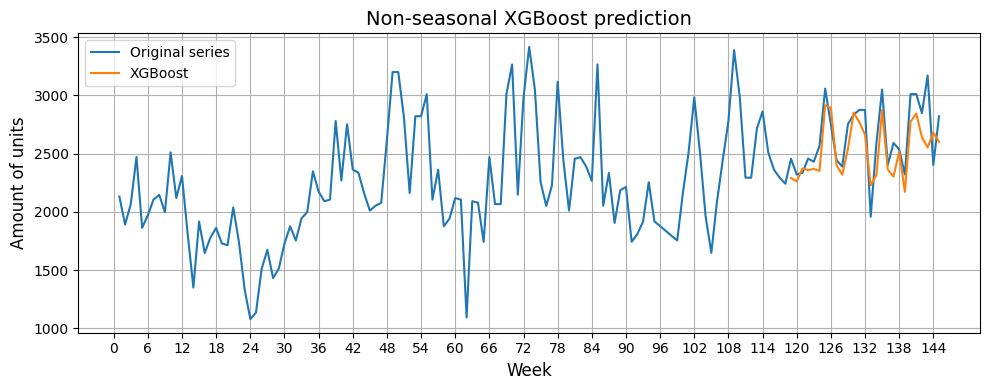

In [57]:
y_pred_xgb = pd.Series(y_pred_xgb , index = X_test_xgb.index)

plot_graph(df_work['num_units'], y_pred_xgb, title = 'Non-seasonal XGBoost prediction', labels = ['Original series', 'XGBoost'], legend = True)

5. Feature Importance

In [101]:
fi = pd.DataFrame({
 'feature': X_train_xgb.columns,
 'importance': search.best_estimator_.feature_importances_}
)

fi.sort_values('importance', ascending=False)

,feature,importance
11,ewm_a03,0.511602
13,roll_8,0.118243
14,roll_12,0.061649
12,roll_4,0.058829
2,lag_2,0.045198
0,t,0.041730
6,lag_6,0.026827
3,lag_3,0.024432
10,lag_10,0.024056
5,lag_5,0.022443


##### _Seasonality 72 weeks_

To include seasonal components in model we need to add:
* Seasonal lag = 72
* 72 point moving average
* Sin / cos signs for period 72

1. Preparing the dataset

In [58]:
df_xgboost_seas = df_work.copy()

# Clear trend - add observation number as a feature
df_xgboost_seas['t'] = np.arange(len(df_xgboost_seas))

# Normal lags 1–6, 54 (1 year), 72 (recommended seasonality)
for lag in [1, 2, 3, 4, 5, 6, 54, 72]:
    df_xgboost_seas[f'lag_{lag}'] = df_xgboost_seas['num_units'].shift(lag)

# 72 points Moving average 
df_xgboost_seas[f'roll_72'] = df_xgboost_seas['num_units'].shift(1).rolling(72).mean()

# Remove gaps
df_xgboost_seas = df_xgboost_seas.dropna() #.reset_index(drop=True)

# Sin / cos for 72 point cycle
t = np.arange(len(df_xgboost_seas))
df_xgboost_seas['sin72'] = np.sin(2 * np.pi * t / 72)
df_xgboost_seas['cos72'] = np.cos(2 * np.pi * t / 72)

df_xgboost_seas

,num_units,t,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_54,lag_72,roll_72,sin72,cos72
week,,,,,,,,,,,,,
73,3417,72,2985.0,2148.0,3266.0,3012.0,2067.0,2067.0,1729.0,2132.0,2109.222222,0.000000e+00,1.000000
74,3051,73,3417.0,2985.0,2148.0,3266.0,3012.0,2067.0,1714.0,1891.0,2127.069444,8.715574e-02,0.996195
75,2256,74,3051.0,3417.0,2985.0,2148.0,3266.0,3012.0,2038.0,2067.0,2143.180556,1.736482e-01,0.984808
76,2051,75,2256.0,3051.0,3417.0,2985.0,2148.0,3266.0,1743.0,2472.0,2145.805556,2.588190e-01,0.965926
77,2229,76,2051.0,2256.0,3051.0,3417.0,2985.0,2148.0,1337.0,1863.0,2139.958333,3.420201e-01,0.939693
...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,3012,140,3012.0,2321.0,2537.0,2593.0,2404.0,3051.0,2335.0,3012.0,2451.319444,-3.420201e-01,0.939693
142,2848,141,3012.0,3012.0,2321.0,2537.0,2593.0,2404.0,1905.0,3266.0,2451.319444,-2.588190e-01,0.965926
143,3172,142,2848.0,3012.0,3012.0,2321.0,2537.0,2593.0,2187.0,2148.0,2445.513889,-1.736482e-01,0.984808


2. Train-Test Splitting

In [59]:
train_xgb_seas, test_xgb_seas = train_test_split(df_xgboost_seas, test_size = 0.2, shuffle = False)

X_train_xgb_seas, y_train_xgb_seas = train_xgb_seas.drop('num_units', axis = 1), train_xgb_seas['num_units']
X_test_xgb_seas, y_test_xgb_seas = test_xgb_seas.drop('num_units', axis = 1), test_xgb_seas['num_units']

3. Modeling

In param_grid_seas we add new parameters:
* **reg_alpha** - L1 regularization - adds to the loss function the sum of the absolute values ​​of the weights of the tree leaves, multiplied by the coefficient reg_alpha;
* **reg_lambda** - L2 regularization - adds to the loss function the sum of the squares of the leaf weights, multiplied by the reg_lambda coefficient.

In [60]:
# Dictionary with hyperparameter grid
param_grid_seas = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.03, 0.05, 0.1], 
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha':[0, 0.5, 1.0],
    'reg_lambda':[1.0, 2.0, 5.0]
}

search_seas = RandomizedSearchCV(
    estimator = XGBRegressor(random_state = 42),
    param_distributions = param_grid_seas,
    n_iter = 100,
    cv = TimeSeriesSplit(n_splits = 5),
    scoring = 'neg_mean_squared_error',
    n_jobs = -1, 
    verbose = 1,
)

# Run hyperparameter selection on training data
search_seas.fit(X_train_xgb_seas, y_train_xgb_seas)

best_params_seas = search_seas.best_params_
print("Best parameters:", best_params_seas)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 0.6, 'reg_lambda': 5.0, 'reg_alpha': 0.5, 'n_estimators': 500, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


In [61]:
# Preparing DMatrix for xgb.train
dtrain_seas = xgb.DMatrix(X_train_xgb_seas, label = y_train_xgb_seas)
dtest_seas = xgb.DMatrix(X_test_xgb_seas,  label = y_test_xgb_seas)

params_seas = best_params.copy()
num_boost_round_seas = best_params.pop('n_estimators')
params_seas.update({
    'objective':   'reg:squarederror',
    'eval_metric': 'rmse'
})

# Training with early stopping 
bst_seas = xgb.train(
    params_seas,
    dtrain_seas,
    num_boost_round = num_boost_round_seas,
    evals = [(dtrain_seas, 'train'), (dtest_seas, 'eval')],
    early_stopping_rounds = 20,
    verbose_eval = False
)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning: [16:14:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


4. Prediction

In [62]:
y_pred_xgb_seas = bst_seas.predict(dtest_seas)

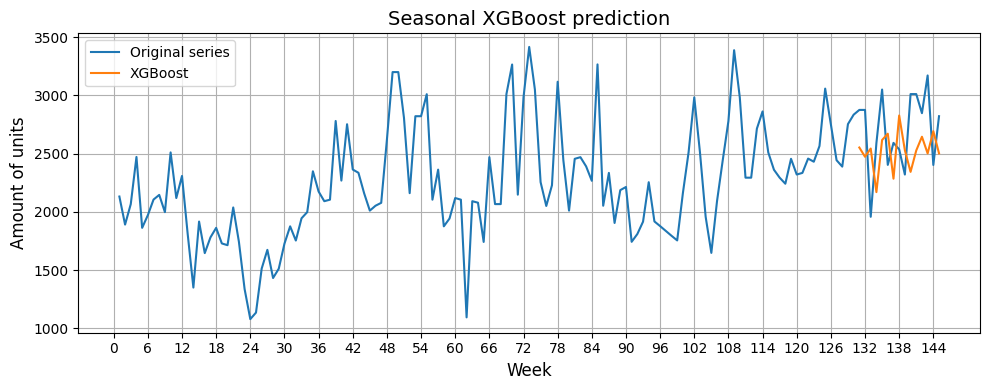

In [63]:
y_pred_xgb_seas = pd.Series(y_pred_xgb_seas, index = X_test_xgb_seas.index)

plot_graph(df_work['num_units'], y_pred_xgb_seas, title = 'Seasonal XGBoost prediction', labels = ['Original series', 'XGBoost'], legend = True)

Unfortunately, as we can see, adding parameters to take into account seasonality in 72 weeks (as well as 24 and 52) did not give good prediction results. Further changes in parameters and strengthen of seasonal and trend features did not give better results.

#### **Random Forest**

##### _Zero seasonality_

1. Preparing the dataset

In [64]:
df_forest = df_work.copy()

for lag in [1, 2, 3, 4, 5, 6, 10, 24]:
    df_forest[f'lag_{lag}'] = df_forest['num_units'].shift(lag)

df_forest['roll_mean_4'] = df_forest['num_units'].rolling(window = 4).mean().shift(1)
df_forest['roll_std_8'] = df_forest['num_units'].rolling(window = 8).std().shift(1)

df_forest = df_forest.dropna()
df_forest

,num_units,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_10,lag_24,roll_mean_4,roll_std_8
week,,,,,,,,,,,
25,1135,1079.0,1337.0,1743.0,2038.0,1714.0,1729.0,1917.0,2132.0,1549.25,305.938369
26,1513,1135.0,1079.0,1337.0,1743.0,2038.0,1714.0,1646.0,1891.0,1323.50,351.456866
27,1674,1513.0,1135.0,1079.0,1337.0,1743.0,2038.0,1781.0,2067.0,1266.00,332.429584
28,1432,1674.0,1513.0,1135.0,1079.0,1337.0,1743.0,1863.0,2472.0,1350.25,328.412388
29,1512,1432.0,1674.0,1513.0,1135.0,1079.0,1337.0,1729.0,1863.0,1438.50,320.779603
...,...,...,...,...,...,...,...,...,...,...,...
141,3012,3012.0,2321.0,2537.0,2593.0,2404.0,3051.0,2876.0,2294.0,2615.75,356.945374
142,2848,3012.0,3012.0,2321.0,2537.0,2593.0,2404.0,2876.0,2242.0,2720.50,292.298160
143,3172,2848.0,3012.0,3012.0,2321.0,2537.0,2593.0,1958.0,2456.0,2798.25,294.013484


2. Train-Test Splitting

In [65]:
train_forest, test_forest = train_test_split(df_forest, test_size = 0.2, shuffle = False)

X_train_forest, y_train_forest = train_forest.drop('num_units', axis = 1), train_forest['num_units']
X_test_forest, y_test_forest = test_forest.drop('num_units', axis = 1), test_forest['num_units']

3. Modeling

In [66]:
# 
param_dist_forest = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20, 50],
    'min_samples_split': list(range(2,21)),
    'min_samples_leaf': list(range(1,11)),
    'max_features': ['sqrt', 'log2', None]
}

search_forest = RandomizedSearchCV(
    estimator = RandomForestRegressor(random_state=42),
    param_distributions = param_dist_forest,
    n_iter = 50,
    scoring = 'neg_mean_squared_error',
    cv = TimeSeriesSplit(n_splits = 5),
    random_state = 42,
    n_jobs = -1,
    error_score = 'raise'
)

search_forest.fit(X_train_forest, y_train_forest)
best_model_forest = search_forest.best_estimator_
print('Best parameters:', best_model_forest)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: RandomForestRegressor(max_features='log2', min_samples_split=4,
                      n_estimators=200, random_state=42)


4. Prediction

In [67]:
y_pred_forest = best_model_forest.predict(X_test_forest)

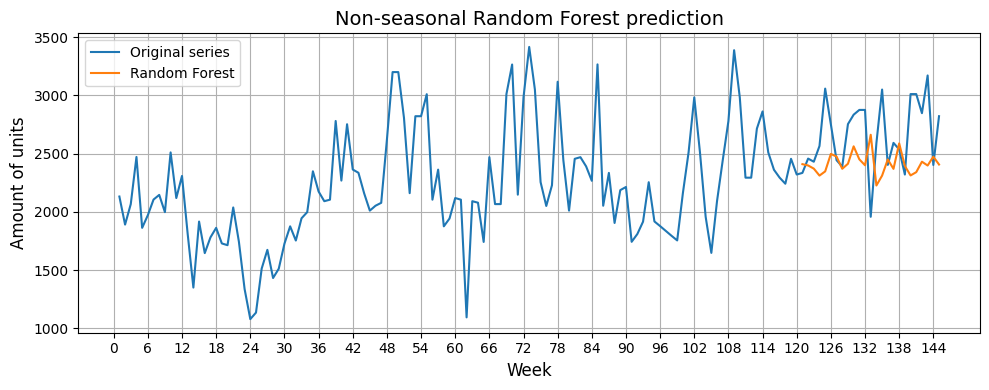

In [68]:
y_pred_forest = pd.Series(y_pred_forest, index = X_test_forest.index)

plot_graph(df_work['num_units'], y_pred_forest, title = 'Non-seasonal Random Forest prediction', labels = ['Original series', 'Random Forest'], legend = True)

##### _Seasonality 72 weeks_

1. Preparing the dataset

In [69]:
df_forest_seas = df_work.copy()

for lag in range(1, 15):
    df_forest_seas[f'lag_{lag}'] = df_forest_seas['num_units'].shift(lag)

df_forest_seas['roll_mean_3'] = df_forest_seas['num_units'].rolling(window=3).mean().shift(1)
df_forest_seas['roll_std_7'] = df_forest_seas['num_units'].rolling(window=7).std().shift(1)

# Add seasonality
df_forest_seas[f'seasonal_72'] = df_forest_seas['num_units'].shift(72)

df_forest_seas = df_forest_seas.dropna()

df_forest_seas['sin72'] = np.sin(2*np.pi*np.arange(len(df_forest_seas))/period)
df_forest_seas['cos72'] = np.cos(2*np.pi*np.arange(len(df_forest_seas))/period)

df_forest_seas

,num_units,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,roll_mean_3,roll_std_7,seasonal_72,sin72,cos72
week,,,,,,,,,,,,,,,,,,,,
73,3417,2985.0,2148.0,3266.0,3012.0,2067.0,2067.0,2470.0,1742.0,2079.0,2092.0,1094.0,2105.0,2119.0,1943.0,2799.666667,507.611681,2132.0,0.000000e+00,1.000000
74,3051,3417.0,2985.0,2148.0,3266.0,3012.0,2067.0,2067.0,2470.0,1742.0,2079.0,2092.0,1094.0,2105.0,2119.0,2850.000000,594.214728,1891.0,8.715574e-02,0.996195
75,2256,3051.0,3417.0,2985.0,2148.0,3266.0,3012.0,2067.0,2067.0,2470.0,1742.0,2079.0,2092.0,1094.0,2105.0,3151.000000,529.985175,2067.0,1.736482e-01,0.984808
76,2051,2256.0,3051.0,3417.0,2985.0,2148.0,3266.0,3012.0,2067.0,2067.0,2470.0,1742.0,2079.0,2092.0,1094.0,2908.000000,486.512370,2472.0,2.588190e-01,0.965926
77,2229,2051.0,2256.0,3051.0,3417.0,2985.0,2148.0,3266.0,3012.0,2067.0,2067.0,2470.0,1742.0,2079.0,2092.0,2452.666667,570.261177,1863.0,3.420201e-01,0.939693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,3012,3012.0,2321.0,2537.0,2593.0,2404.0,3051.0,2592.0,1958.0,2876.0,2876.0,2835.0,2754.0,2389.0,2444.0,2623.333333,282.770646,3012.0,-3.420201e-01,0.939693
142,2848,3012.0,3012.0,2321.0,2537.0,2593.0,2404.0,3051.0,2592.0,1958.0,2876.0,2876.0,2835.0,2754.0,2389.0,2781.666667,312.792644,3266.0,-2.588190e-01,0.965926
143,3172,2848.0,3012.0,3012.0,2321.0,2537.0,2593.0,2404.0,3051.0,2592.0,1958.0,2876.0,2876.0,2835.0,2754.0,2957.333333,283.311204,2148.0,-1.736482e-01,0.984808


2. Train-Test Splitting

In [70]:
train_forest_seas, test_forest_seas = train_test_split(df_forest, test_size = 0.2, shuffle = False)

X_train_forest_seas, y_train_forest_seas = train_forest_seas.drop('num_units', axis = 1), train_forest_seas['num_units']
X_test_forest_seas, y_test_forest_seas = test_forest_seas.drop('num_units', axis = 1), test_forest_seas['num_units']

3. Modeling

In [71]:
param_dist_forest_seas = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

search_forest_seas = RandomizedSearchCV(
    estimator = RandomForestRegressor(random_state=42),
    param_distributions = param_dist_forest,
    n_iter = 50,
    scoring = 'neg_mean_squared_error',
    cv = TimeSeriesSplit(n_splits = 5),
    random_state = 42,
    n_jobs = -1,
    error_score = 'raise'
)

search_forest_seas.fit(X_train_forest_seas, y_train_forest_seas)
best_model_forest_seas = search_forest_seas.best_estimator_
print('Best parameters:', best_model_forest_seas)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: RandomForestRegressor(max_features='log2', min_samples_split=4,
                      n_estimators=200, random_state=42)


4. Prediction

In [72]:
y_pred_forest_seas = best_model_forest_seas.predict(X_test_forest_seas)

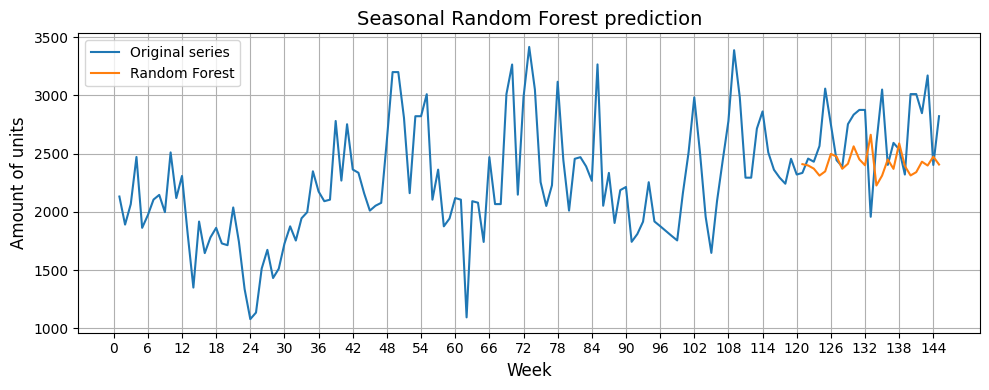

In [73]:
y_pred_forest_seas = pd.Series(y_pred_forest_seas, index = X_test_forest_seas.index)

plot_graph(df_work['num_units'], y_pred_forest_seas, title = 'Seasonal Random Forest prediction', labels = ['Original series', 'Random Forest'], legend = True)

## 7. Evaluation of predictions

Now, wneh we have received all the predictions from the models, we can compare them and identify the best one that makes less errors:

In [74]:
metrics_accur = accurancy_metrics(metrics_accur, 'Arima (1,1,1)', df_work_ds['num_units'], sf_arima_forecast['AutoARIMA'])
metrics_accur = accurancy_metrics(metrics_accur, 'Sarima (1,1,1)', df_work_ds['num_units'],sf_sarima_forecast['AutoARIMA'])
metrics_accur = accurancy_metrics(metrics_accur, 'XGBoost nonseasonal', df_work['num_units'], y_pred_xgb)
metrics_accur = accurancy_metrics(metrics_accur, 'XGBoost seasonal', df_work['num_units'], y_pred_xgb_seas)
metrics_accur = accurancy_metrics(metrics_accur, 'Random Forest nonseasonal', df_work['num_units'], y_pred_forest)
metrics_accur = accurancy_metrics(metrics_accur, 'Random Forest seasonal', df_work['num_units'], y_pred_forest_seas, True)

,Model,MSE,RMSE,MAPE
0,"Arima (1,1,1)",118223.960245,343.837113,0.095582
1,"Sarima (1,1,1)",118223.960245,343.837113,0.095582
2,XGBoost nonseasonal,43286.780961,208.054755,0.062867
3,XGBoost seasonal,175164.233194,418.526263,0.146003
4,Random Forest nonseasonal,174710.911758,417.984344,0.119162
5,Random Forest seasonal,174710.911758,417.984344,0.119162


Accordingly, we see that nonseasonal XGBoost model shows the best result for all three metrics. This means that we will use it for next forecast.

## 8. Forecast

We will forecast the order level for the next 8 weeks (2 months).  
To use the Xgboost model, we also prepare variables that will describe changes in the behavior of the demand level. After that, these features will be passed to the trained model that was used in Part 6-2 - 'Nonseasonal Xgboost':   
* trend;
* lags;
* exponent;
* moving average.  

At the end, we will also calculate the upper and lower confidence intervals.

In [96]:
# Preparation of components necessary for calculation in features and forecast
history = df_work.copy()
last_week = history.index[-1]

# forecast for 8 weeks
step_forecast = 8

# Previous value of t on 145th week
t_last = df_xgboost['t'].iloc[-1]

# Components for finding a confidence interval
sigma = np.std(y_test_xgb - y_pred_xgb, ddof = 0)
alpha = 1.96  # for ~95% CI

In [97]:
for i in range(1, step_forecast + 1):
    week = last_week + i

    # Creating features for forecast model
    history.at[week, 't'] = t_last + i
    
    prev = history.loc[:week, 'num_units']

    for lag in range(1, 11):
        history.at[week, f'lag_{lag}'] = prev.iloc[-lag-1]

    ewm_val = prev.ewm(alpha=0.3, adjust=False).mean().iloc[-2]
    history.at[week, 'ewm_a03'] = ewm_val

    for w in (4, 8, 12):
        history.at[week, f'roll_{w}'] = prev.iloc[-w-1 : ].mean()

    # Forecast
    dnew = xgb.DMatrix(history.loc[[week], ['t', *(f'lag_{l}' for l in range(1,11)), 'ewm_a03', *(f'roll_{w}' for w in (4,8,12))]])
    y_forecast = bst.predict(dnew)[0]

    history.loc[week, 'num_units'] = y_forecast

    # Confidence interval
    history.at[week, 'lower_95%'] = (y_forecast - alpha * sigma)
    history.at[week, 'upper_95%'] = (y_forecast + alpha * sigma)

history.tail(10)

,num_units,t,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,ewm_a03,roll_4,roll_8,roll_12,lower_95%,upper_95%
week,,,,,,,,,,,,,,,,,,
144,2403.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,2822.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,2698.534180,145.0,2822.000000,2403.000000,3172.000000,2848.000000,3012.000000,3012.000000,2321.00000,2537.0,2593.0,2404.0,2774.203326,2811.250000,2765.875000,2730.583333,2355.836869,3041.231490
147,2598.792236,146.0,2698.534180,2822.000000,2403.000000,3172.000000,2848.000000,3012.000000,3012.00000,2321.0,2537.0,2593.0,2751.502582,2773.883545,2786.066772,2739.461182,2256.094926,2941.489547
148,2621.257324,147.0,2598.792236,2698.534180,2822.000000,2403.000000,3172.000000,2848.000000,3012.00000,3012.0,2321.0,2537.0,2705.689478,2630.581604,2820.790802,2701.777201,2278.560014,2963.954635
149,2718.924072,148.0,2621.257324,2598.792236,2698.534180,2822.000000,2403.000000,3172.000000,2848.00000,3012.0,3012.0,2321.0,2680.359832,2685.145935,2771.947968,2719.881978,2376.226762,3061.621383
150,2737.947266,149.0,2718.924072,2621.257324,2598.792236,2698.534180,2822.000000,2403.000000,3172.00000,2848.0,3012.0,3012.0,2691.929104,2659.376953,2735.313477,2730.375651,2395.249955,3080.644576
151,2682.571777,150.0,2737.947266,2718.924072,2621.257324,2598.792236,2698.534180,2822.000000,2403.00000,3172.0,2848.0,3012.0,2705.734553,2669.230225,2721.556885,2747.121257,2339.874467,3025.269088
152,2698.675049,151.0,2682.571777,2737.947266,2718.924072,2621.257324,2598.792236,2698.534180,2822.00000,2403.0,3172.0,2848.0,2698.785720,2690.175110,2660.378357,2777.252238,2355.977738,3041.372359


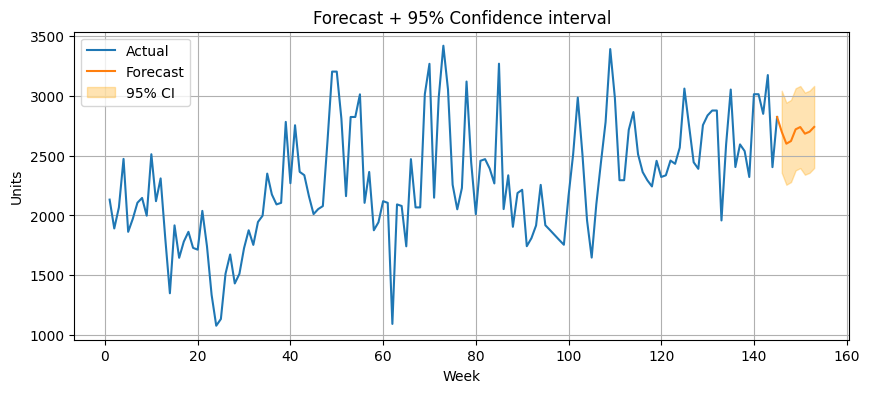

In [99]:
# Visualization
plt.figure(figsize=(10,4))

# Fact
plt.plot(df_work['num_units'], label = 'Actual')

# Forecast and CI
plt.plot(history['num_units'][-9:], label = 'Forecast')
plt.fill_between(history.index, history['lower_95%'], history['upper_95%'], color = 'orange', alpha=0.3, label = '95% CI')

plt.xlabel('Week')
plt.ylabel('Units')
plt.title('Forecast + 95% Confidence interval')
plt.legend()
plt.grid(True)

plt.show()

## 9. Conclusion

In [107]:
print('So for the next 8 weeks it is necessary to order the following amount of drinks:\n')

for w, u in history['num_units'].tail(8).items():
    print(f'For week {w}: {int(u)} beverages')

So for the next 8 weeks it is necessary to order the following amount of drinks:

For week 146: 2698 beverages
For week 147: 2598 beverages
For week 148: 2621 beverages
For week 149: 2718 beverages
For week 150: 2737 beverages
For week 151: 2682 beverages
For week 152: 2698 beverages
For week 153: 2738 beverages


We can see that the forecast of the future order level does not look quite plausible. This may be due to the fact that for the trained model `bst`, the main important feature was exponential smoothing, which is done based on current values, which in this particular case were unknown.  

As an improvement in the forecast in the future, we can try:
* to improve the current models, for example, changing the method for finding superparameters for XgBoost and Random Forest using **Grid / Bayes search** insted Random search;
* to look at other forecasting models, namely for ML this is **SVR**, or for DL this is **TCN**, **LSTM**, Facebook's **Prophet**